In [1]:
from openket import *
from scipy.integrate import odeint
from sympy import var, I
import numpy as np
import matplotlib.pyplot as plt
import math

2025-10-15 01:27:37,767 - openket - INFO - openket v0.1.0 initialized successfully.


In [2]:
cmap = plt.cm.Accent

In [3]:
hbar = 1.0
omega_c = 1.0 # frecuencia de la cavidad (unidad de referencia)
omega_b = 1.0 # frecuencia del bombeo (unidad de referencia)
rabi_b = 1.5 # tasa del bombeo, proporcional a la amplitud del campo eléctrico del láser
detuning = omega_c - omega_b # detuning entre frecuencia de la cavidad y frecuencia del bombeo

kappa = 1.0
nmax = 20 # truncación del espacio de Hilbert (número de estados de Fock)
dt = 1000
t = np.linspace(0, 15, dt)

base = [Ket(i, "cavidad") for i in range(nmax)]
rho = Operator("R")
a = AnnihilationOperator("cavidad", nmax-1)
aa = CreationOperator("cavidad", nmax-1)

In [4]:
H_c = hbar * detuning * (aa * a + 1 / 2) # Hamiltoniano del oscilador armónico cuántico (cavidad)
H_b = hbar * rabi_b * (aa + a) # Hamiltoniano del bombeo (láser)
H = H_c + H_b # Hamiltoniano total
# ecuación de movimiento de Lindblad
rdot = I/hbar * comm(H,rho) + (kappa/2)*(2*a*rho*aa - aa*a*rho - rho*aa*a)

In [15]:
build_ode(rho=rho, rdot=rdot, basis=base, filetype="Scipy", filename="func.py")

In [5]:
from func import dic, f
# convertir condiciones iniciales simbólicas -> numéricas
rho0 = Ket(0,"cavidad") * dag(Ket(0,"cavidad"))
init_conditions = init_state(rho=rho, rho0=rho0, basis=base, dic=dic)
# solución numérica
rho_solution = odeint(f, init_conditions, t)

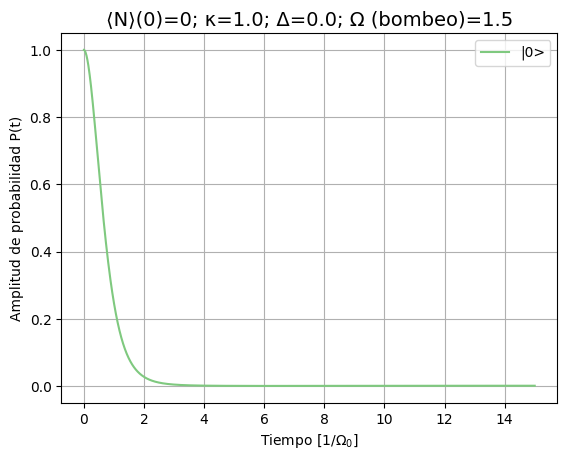

In [6]:
# Probabilidad
rho_complex = rho_solution[:, ::2] + 1j * rho_solution[:, 1::2] # convierte la matriz a entradas complejas
rho_complex = rho_complex.reshape(dt, nmax, nmax) # pasa de matriz plana a matriz densidad nxn para cada t
rho_nn = np.diagonal(np.abs(rho_complex), axis1=1, axis2=2) # extrae los elementos diagonales

estados = [0]
for i in estados:
    plt.plot(t, rho_nn[:,i], label=f'|{i}>', color=cmap(i))
plt.xlabel('Tiempo [$1/Ω_0$]')
plt.ylabel('Amplitud de probabilidad P(t)')
plt.title(f'⟨N⟩(0)=0; κ={kappa}; Δ={detuning}; Ω (bombeo)={rabi_b}', fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

In [7]:
# Valores esperados numéricos
# definición simbólica de los observables
N = aa * a # operador de número
X = (1/np.sqrt(2)) * (a+aa) # cuadratura X adimensional
P = (1/np.sqrt(2)) * I*(aa-a) # cuadratura P adimensional

N_symb = sub_qexpr(qexpr=trace(rho * N, basis=base), dic=dic)
X_symb = sub_qexpr(qexpr=trace(rho * X, basis=base), dic=dic)
P_symb = sub_qexpr(qexpr=trace(rho * P, basis=base), dic=dic)

N_expect = sym2num(sol=rho_solution, symbexpr=N_symb)
X_expect = sym2num(sol=rho_solution, symbexpr=X_symb)
P_expect = sym2num(sol=rho_solution, symbexpr=P_symb)

In [16]:
# Valores esperados analíticos
alpha_ss = rabi_b / (kappa/2 + 1j*detuning) #amplitud compleja del estado estacionario (cuando t->oo)
alpha = alpha_ss*(1 - np.exp(-(kappa/2 + 1j*detuning) * t)) #amplitud compleja del campo coherente en la cavidad

N_analytical = np.abs(alpha)**2
X_analytical = np.sqrt(2) * np.imag(alpha)
P_analytical = np.sqrt(2) * np.real(alpha)

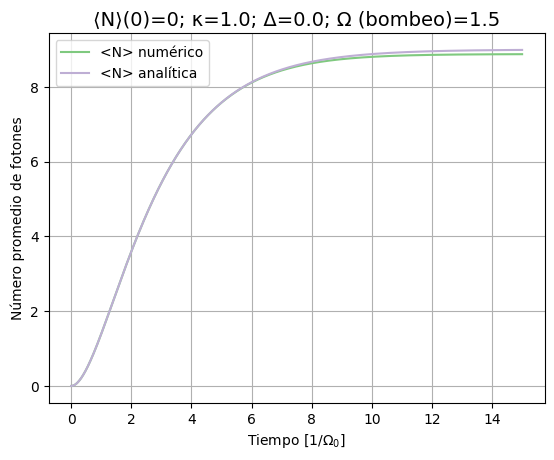

In [17]:
plt.plot(t, np.real(N_expect), label='<N> numérico', color=cmap(0))
plt.plot(t, N_analytical, label='<N> analítica', color=cmap(1))
plt.title(f'⟨N⟩(0)=0; κ={kappa}; Δ={detuning}; Ω (bombeo)={rabi_b}', fontsize=14)
plt.xlabel('Tiempo [$1/Ω_0$]')
plt.ylabel('Número promedio de fotones')
plt.legend()
plt.grid()
plt.show()

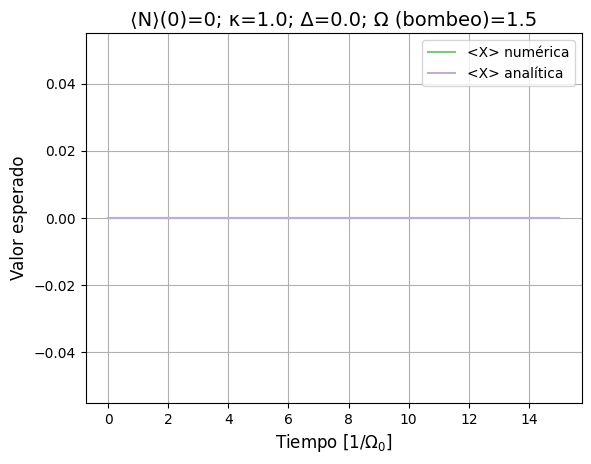

In [18]:
plt.plot(t, np.real(X_expect), label='<X> numérica', color=cmap(0))
plt.plot(t, X_analytical, label='<X> analítica', color=cmap(1))
plt.title(f'⟨N⟩(0)=0; κ={kappa}; Δ={detuning}; Ω (bombeo)={rabi_b}', fontsize=14)
plt.xlabel('Tiempo [$1/Ω_0$]', fontsize=12)
plt.ylabel('Valor esperado', fontsize=12)
plt.legend()
plt.grid()
plt.show()

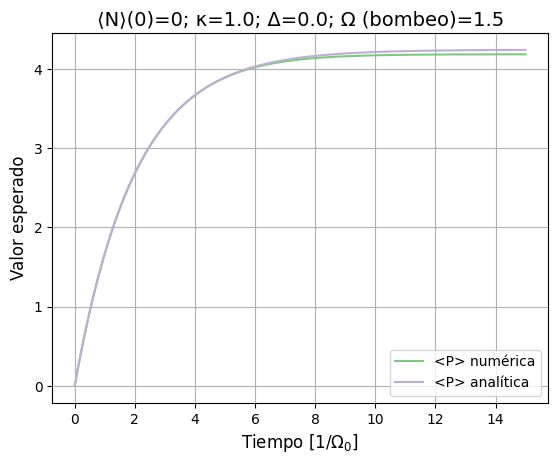

In [19]:
plt.plot(t, np.real(P_expect), label='<P> numérica', color=cmap(0))
plt.plot(t, P_analytical, label='<P> analítica', color=cmap(1))
plt.title(f'⟨N⟩(0)=0; κ={kappa}; Δ={detuning}; Ω (bombeo)={rabi_b}', fontsize=14)
plt.xlabel('Tiempo [$1/Ω_0$]', fontsize=12)
plt.ylabel('Valor esperado', fontsize=12)
plt.legend()
plt.grid()
plt.show()